In [1]:
! pip install -q -U git+https://github.com/google-research/neuralgcm git+https://github.com/google-research/dinosaur

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.3 MB/s eta 0:00:00


# NeuralGCM model inference demo

This notebook uses ERA5 data and pretrained NeuralGCM model to make a forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

We recommend using large RAM GPU or TPU runtime for this notebook due to high memory and compute requirements. By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochstaic 1.4° NeuralGCM variations.

In [2]:
import os

import fsspec
import gcsfs
import gin
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import pytree_utils
from dinosaur import spherical_harmonic
from dinosaur import vertical_interpolation
from dinosaur import xarray_utils
from neuralgcm import api

gcs = gcsfs.GCSFileSystem(token='anon')

In [3]:
# Selecting NeuralGCM model to run inference with

model_name = 'neural_gcm_deterministic_1_4_deg_v0.pkl'  #@param ['neural_gcm_deterministic_0_7_deg_v0.pkl', 'neural_gcm_deterministic_2_8_deg_v0.pkl', 'neural_gcm_deterministic_1_4_deg_v0.pkl', 'neural_gcm_stochastic_1_4_deg_v0.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/03_04_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

neuralgcm_vars = [
    'u_component_of_wind',
    'v_component_of_wind',
    'geopotential',
    'temperature',
    'specific_humidity',
    'specific_cloud_ice_water_content',
    'specific_cloud_liquid_water_content',
    'sea_surface_temperature',
    'sea_ice_cover',
]

neural_gcm_model = api.PressureLevelModel.from_checkpoint(ckpt)

In [4]:
# Loading ERA5 data from Google Cloud arco project

era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5_ds = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)
full_era5_ds = full_era5_ds[neuralgcm_vars]
# For NeuralGCM we take "sea_ice_cover" and "sea_surface_temperature" shifted
# backwards by 24 hours to avoid using information from the assimilation window
# that extends substantially into the future.
full_era5_ds = xarray_utils.xarray_selective_shift(
    dataset=full_era5_ds,
    variables=['sea_ice_cover', 'sea_surface_temperature'],
    time_shift='24 hours',
)

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5_ds.sizes['latitude'],
    longitude_nodes=full_era5_ds.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5_ds.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5_ds.longitude),
)

In [5]:
# Selecting ERA5 data to be used in inference demo

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24  # process every 24th hour

era5_ds = full_era5_ds.sel(time=slice(demo_start_time, demo_end_time))
era5_ds = era5_ds.thin(time=data_inner_steps)
era5_ds = era5_ds.compute()  # must load before regridding.
if not (era5_ds['latitude'].diff('latitude') > 0).all():
  # Ensure ascending latitude.
  era5_ds = era5_ds.isel(latitude=slice(None, None, -1))

In [6]:
# Regridding original ERA5 data to a coarser resolution.

target_grid = neural_gcm_model.data_coords.horizontal
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, target_grid)

eval_ds = xarray.apply_ufunc(  # running regridding
    regridder,
    era5_ds,
    input_core_dims=[['longitude', 'latitude']],
    output_core_dims=[['longitude', 'latitude']],
    exclude_dims={'longitude', 'latitude'},
    vectorize=True,  # loops over level, for lower memory usage
)
# sea_ice_cover and sea_surface_temperature in ERA5 contain `nan`, we replace
# them with nearest neighbor values to avoid accidental `nan` injection. For
# the most part such entries are ignored by NeuralGCMs as sea_land_model does
# not use SST values over land.
eval_ds = xarray_utils.fill_nan_with_nearest(eval_ds)

# assign new coordinates to the regridded dataset.
new_lon = 180 / np.pi * target_grid.longitudes
new_lat = 180 / np.pi * target_grid.latitudes
eval_ds.coords['longitude']  = new_lon
eval_ds.coords['latitude']  = new_lat

# Note: Assigning lon/lat coordinates prior to performing
# `fill_nan_with_nearest` would be more appropriate, but here we follow the
# steps that were done during training for reproducibility.

/usr/local/lib/python3.10/dist-packages/dinosaur/xarray_utils.py:1053: RuntimeWarning: invalid value encountered in sqrt
  indices = tree.query(query_coords, return_distance=False).squeeze(axis=-1)
/usr/local/lib/python3.10/dist-packages/dinosaur/xarray_utils.py:1053: RuntimeWarning: invalid value encountered in sqrt
  indices = tree.query(query_coords, return_distance=False).squeeze(axis=-1)


In [7]:
# Selecting input data and rollout parameters

inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

input_data_ds = eval_ds.isel(time=slice(0, 1))  # keep time axis for `forcings`.
data_dict, forcings = neural_gcm_model.data_from_xarray(input_data_ds)
# slicing time=0 for initializing the model (encode expects no time axis)
inputs, input_forcings = pytree_utils.slice_along_axis(
    (data_dict, forcings), axis=0, idx=0)

# Note: rng_key is optional (and unused) by deterministic models.
initial_state = neural_gcm_model.encode(
    inputs, forcings=input_forcings, rng_key=jax.random.PRNGKey(42)
)
final_state, predictions = neural_gcm_model.unroll(
    initial_state,
    forcings=forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

# format rollout predictions to xarray.Dataset with labeled coordinates.
predictions_ds = neural_gcm_model.data_to_xarray(predictions, times=times)

/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:361: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),
/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:362: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),


In [8]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory, _ = neural_gcm_model.data_from_xarray(
    eval_ds.thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(None, outer_steps)))
target_data_ds = neural_gcm_model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

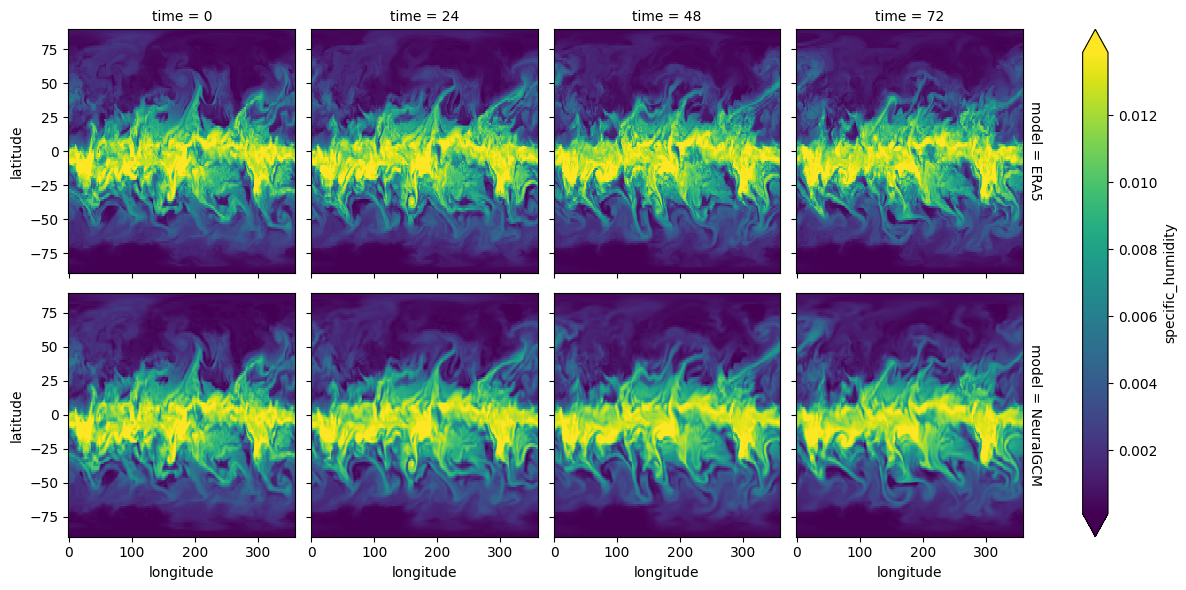

In [9]:
# Visualization of ERA5 vs NeuralGCM trajectories
variable = 'specific_humidity'
level = 850
combined_ds[variable].sel(level=level).plot(
    x='longitude', y='latitude', col='time', row='model', robust=True)